In [1]:
#!pip install tqdm
#!conda install shapely descartes geopandas -y

In [2]:
# general tools
import warnings
import requests
import pickle
import math
import re

# visualization tools
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

# data preprocessing tools
import pandas as pd
from shapely.geometry import Point
import numpy as np
from scipy.spatial.distance import cdist


tqdm.pandas()
plt.style.use('seaborn')
warnings.filterwarnings("ignore")

#%run ../src/utils.py

In [12]:
traffic = pd.read_csv('../data/external/Traffic_Published_2016.csv')
traffic.shape

(94258, 16)

In [13]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94258 entries, 0 to 94257
Data columns (total 16 columns):
ROUTE_ID                94258 non-null object
FROM_MILEPOINT          94258 non-null float64
TO_MILEPOINT            94258 non-null float64
COUNTY_COD              91713 non-null float64
COUNTY_NAME             91713 non-null object
TC_NUMBER               41239 non-null object
AADT                    94258 non-null int64
AADT_SINGLE_UNIT        44070 non-null float64
PCT_PEAK_SINGLE         42724 non-null float64
AADT_COMBINATION        43403 non-null float64
PCT_PEAK_COMBINATION    37597 non-null float64
K_FACTOR                83781 non-null float64
D_Factor                41095 non-null float64
FUTURE_AADT             94239 non-null float64
Lat                     40984 non-null float64
Long                    40984 non-null float64
dtypes: float64(12), int64(1), object(3)
memory usage: 11.5+ MB


In [14]:
traffic = traffic.dropna(subset=['Lat'])
traffic.shape

(40984, 16)

In [15]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0', low_memory=True)
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)

train.shape, test.shape

((814262, 11), (202937, 11))

In [16]:
data = pd.concat([train, test], axis=0)

data.shape

(1017199, 11)

In [17]:
import pyproj

converter = pyproj.Proj("+proj=merc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 \
                    +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

data['lat_lon_entry'] = [converter(x, y, inverse=True) for x, y in zip(data.x_entry, data.y_entry)]

data['lat_entry'] = data.lat_lon_entry.apply(lambda row: row[0])
data['lon_entry'] = data.lat_lon_entry.apply(lambda row: row[1])

data['lat_lon_exit'] = [converter(x, y, inverse=True) for x, y in zip(data.x_exit, data.y_exit)]

data['lat_exit'] = data.lat_lon_exit.apply(lambda row: row[0])
data['lon_exit'] = data.lat_lon_exit.apply(lambda row: row[1])

In [18]:
def euclidean(x_one, y_one, x_two, y_two):
    """Distance as defined by the Euclidean formula for the ((x1, y1), (x2, y2)) case."""
    return np.sqrt(np.power((x_one-x_two), 2) + np.power((y_one-y_two), 2))

data['euclidean_distance'] = euclidean(data.x_entry.values, data.y_entry.values,
                                      data.x_exit.values, data.y_exit.values)

In [19]:
from math import hypot
from scipy.spatial.distance import cdist
from tqdm import tqdm

traffic = traffic.reset_index(drop=True)
coords_traff = list(zip(traffic.Lat.values, traffic.Long.values))
data['idx_traffic'] = np.zeros(data.shape[0])

df_copy = data.copy()
df_copy = df_copy[df_copy.euclidean_distance!=0]
df_copy = df_copy.reset_index(drop=True)

def minimum_distance(data, row_type='entry'):
    for idx, (lat, long) in tqdm(enumerate(list(zip(data['lat_'+row_type].values, data['lon_'+row_type].values)))):
        minimum_dist = 0

        idx_traffic = cdist([(lat, long)], coords_traff).argmin()
        data.loc[idx, 'idx_traffic'] = idx_traffic
        
    return data

df_copy = minimum_distance(df_copy, row_type='exit')

491966it [1:40:30, 81.58it/s]


In [21]:
df_copy['idx_traffic'] = df_copy.idx_traffic.astype(int)

In [22]:
df_copy.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,lat_lon_entry,lat_entry,lon_entry,lat_lon_exit,lat_exit,lon_exit,euclidean_distance,idx_traffic
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,"(33.695930000000004, -84.3014476969898)",33.69593,-84.301448,"(33.689750000000004, -84.33910917018206)",33.68975,-84.339109,42364.863118,17316
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,"(33.63236000000001, -84.50167564792125)",33.63236,-84.501676,"(33.64167999999999, -84.49926159813707)",33.64168,-84.499262,2989.643628,39609
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,"(33.640719999999995, -84.47674038855256)",33.64072,-84.476740,"(33.640250000000016, -84.47611452311658)",33.64025,-84.476115,725.658561,21659
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,"(33.640829999999994, -84.47563767324873)",33.64083,-84.475638,"(33.640190000000004, -84.47407797673429)",33.64019,-84.474078,1804.576849,22050


In [27]:
traffic_cols = traffic.columns.tolist()

traffic = traffic.reset_index(drop=False)
#traffic.columns = ['idx_traffic']+[traffic_cols]

df_copy['index'] = df_copy.idx_traffic.values

df_final = df_copy.merge(traffic, on='index')
df_final.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,AADT,AADT_SINGLE_UNIT,PCT_PEAK_SINGLE,AADT_COMBINATION,PCT_PEAK_COMBINATION,K_FACTOR,D_Factor,FUTURE_AADT,Lat,Long
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,370,NaN,NaN,NaN,NaN,NaN,100.0,440.0,33.6943,-84.3442
1,004f2f3b69825c9a91ffcfb2d41bd5bc_31,traj_004f2f3b69825c9a91ffcfb2d41bd5bc_31_1,02:29:10,02:35:35,NaN,NaN,NaN,3.753847e+06,-1.914953e+07,3.750332e+06,...,370,NaN,NaN,NaN,NaN,NaN,100.0,440.0,33.6943,-84.3442
2,053952433b521f11fa16cffdc99d7e1e_9,traj_053952433b521f11fa16cffdc99d7e1e_9_4,08:26:31,09:35:34,20.409084,20.409084,20.409084,3.754351e+06,-1.914391e+07,3.751110e+06,...,370,NaN,NaN,NaN,NaN,NaN,100.0,440.0,33.6943,-84.3442
3,053952433b521f11fa16cffdc99d7e1e_9,traj_053952433b521f11fa16cffdc99d7e1e_9_7,11:26:05,11:31:00,NaN,NaN,NaN,3.749769e+06,-1.914668e+07,3.751115e+06,...,370,NaN,NaN,NaN,NaN,NaN,100.0,440.0,33.6943,-84.3442


['hash',
 'trajectory_id',
 'AADT_exit',
 'FUTURE_AADT_exit',
 'PCT_PEAK_SINGLE_exit',
 'COUNTY_COD_exit',
 'COUNTY_NAME_exit',
 'Long_exit',
 'AADT_COMBINATION_exit',
 'K_FACTOR_exit',
 'FROM_MILEPOINT_exit',
 'TC_NUMBER_exit',
 'Lat_exit',
 'ROUTE_ID_exit',
 'PCT_PEAK_COMBINATION_exit',
 'TO_MILEPOINT_exit',
 'AADT_SINGLE_UNIT_exit',
 'D_Factor_exit']

In [38]:
final_columns = list(set(traffic.columns.tolist()) - set(['level_0', 'index']))
final_columns += ['hash', 'trajectory_id']

for col in final_columns:
    if col not in ['hash', 'trajectory_id']:
        df_final = df_final.rename(index=str, columns={col: col+'_exit'})

df_final.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,AADT_exit,AADT_SINGLE_UNIT_exit,PCT_PEAK_SINGLE_exit,AADT_COMBINATION_exit,PCT_PEAK_COMBINATION_exit,K_FACTOR_exit,D_Factor_exit,FUTURE_AADT_exit,Lat_exit,Long_exit
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,370,NaN,NaN,NaN,NaN,NaN,100.0,440.0,33.6943,-84.3442
1,004f2f3b69825c9a91ffcfb2d41bd5bc_31,traj_004f2f3b69825c9a91ffcfb2d41bd5bc_31_1,02:29:10,02:35:35,NaN,NaN,NaN,3.753847e+06,-1.914953e+07,3.750332e+06,...,370,NaN,NaN,NaN,NaN,NaN,100.0,440.0,33.6943,-84.3442
2,053952433b521f11fa16cffdc99d7e1e_9,traj_053952433b521f11fa16cffdc99d7e1e_9_4,08:26:31,09:35:34,20.409084,20.409084,20.409084,3.754351e+06,-1.914391e+07,3.751110e+06,...,370,NaN,NaN,NaN,NaN,NaN,100.0,440.0,33.6943,-84.3442
3,053952433b521f11fa16cffdc99d7e1e_9,traj_053952433b521f11fa16cffdc99d7e1e_9_7,11:26:05,11:31:00,NaN,NaN,NaN,3.749769e+06,-1.914668e+07,3.751115e+06,...,370,NaN,NaN,NaN,NaN,NaN,100.0,440.0,33.6943,-84.3442


In [39]:
final_columns = ['hash', 'trajectory_id'] + [col+'_exit' for col in final_columns if col not in ['hash', 'trajectory_id']]

In [41]:
df_final[final_columns].head(4)

df_final = df_final.drop('COUNTY_NAME_exit', axis=1)

In [43]:
final_columns = list(set(final_columns) - set(['COUNTY_NAME_exit']))

In [44]:
df_final[final_columns].to_hdf('../data/external/traffic_exit_features.hdf', key='exit', mode='w')

######################## Exploring data and some visualizations #################

In [3]:
traffic_exit = pd.read_hdf('../data/raw/traffic_exit_features.hdf', key='exit', mode='r')
traffic_entry = pd.read_hdf('../data/raw/traffic_entry_features.hdf', key='entry', mode='r')

traffic_entry.shape, traffic_exit.shape

((491966, 17), (491966, 17))

In [9]:
traffic_entry.head(4).T

,0,1,2,3
ROUTE_ID_entry,1089200514900INC,1089200514900INC,1089200514900INC,1089200514900INC
AADT_COMBINATION_entry,NaN,NaN,NaN,NaN
TC_NUMBER_entry,089-3792,089-3792,089-3792,089-3792
FUTURE_AADT_entry,13700,13700,13700,13700
AADT_SINGLE_UNIT_entry,NaN,NaN,NaN,NaN
trajectory_id,traj_0000a8602cf2def930488dee7cdad104_1_0,traj_00188565f0b670b9dfa12e24c0143391_15_8,traj_0044cf44561b16a20170eafd71a23275_23_0,traj_0044cf44561b16a20170eafd71a23275_23_13
Long_entry,-84.3043,-84.3043,-84.3043,-84.3043
Lat_entry,33.6943,33.6943,33.6943,33.6943
COUNTY_COD_entry,89,89,89,89
K_FACTOR_entry,9.27,9.27,9.27,9.27


- AADT: Annual Average Daily Traffic (AADT), is the total volume of vehicle traffic. of a roadway for a year divided by 365 days.
- K_FACTOR: is defined as the proportion of annual average daily traffic occurring in an hour. This factor is used for designing and analyzing the flow of traffic on highways.
- ROUTE_ID: Integer value representing each road on Georgia Federative's roads.

In [ ]:
29.8% red, 74.1% green and 74.9% blue

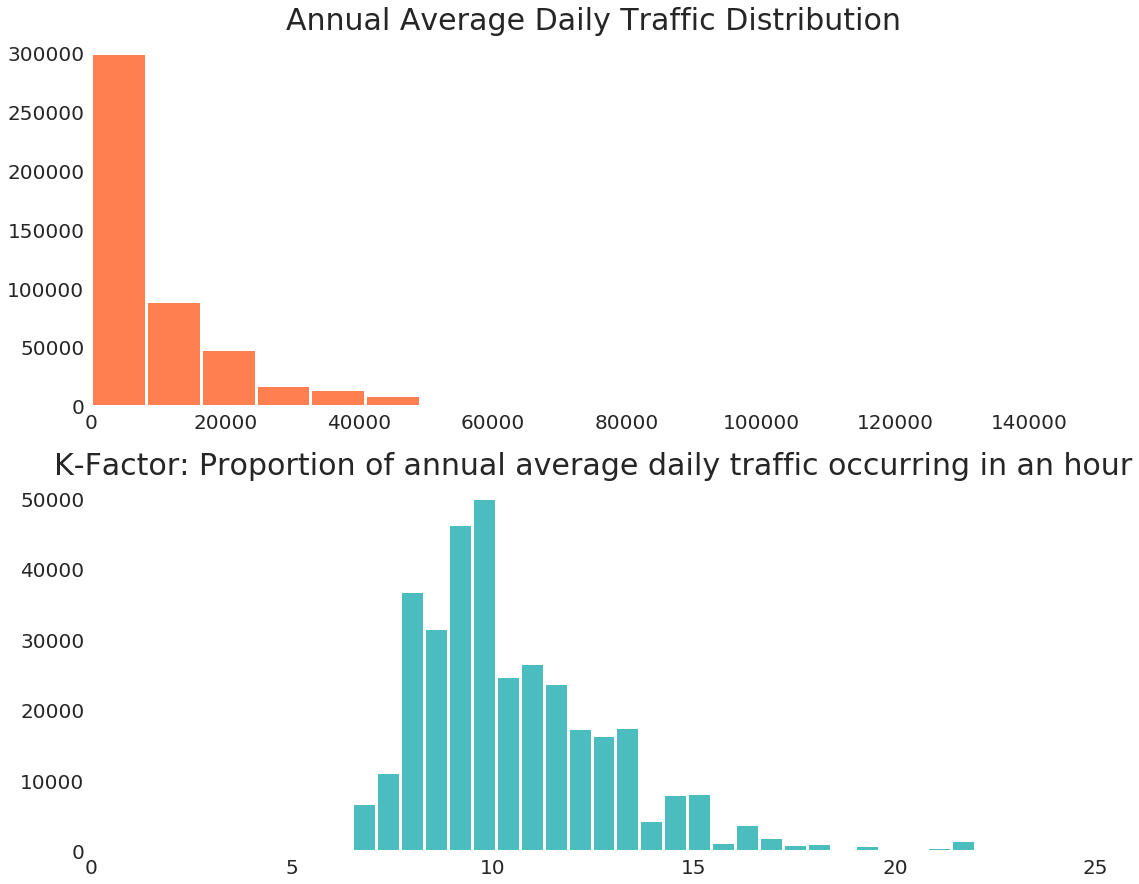

In [59]:
fig, ax = plt.subplots(2, 1, figsize=(18, 15))

sns.set_style("whitegrid")
sns.distplot(traffic_entry.AADT_entry.dropna().values, 
             kde=False, 
             hist_kws={"linewidth": 3, 
                       "alpha": 1, 
                       "color": "coral"},
            ax=ax[0])

sns.distplot(traffic_entry.K_FACTOR_entry.dropna().values, 
             kde=False, 
             hist_kws={"linewidth": 3, 
                       "alpha": 1, 
                       "color": [(0.298, 0.741, 0.749)]},
            ax=ax[1])

ax[0].set_title('Annual Average Daily Traffic Distribution', fontsize=30)
ax[1].set_title('K-Factor: Proportion of annual average daily traffic occurring in an hour',
                fontsize=30)

ax[0].set_xlim(0, 150000)
ax[1].set_xlim(0, 25)

ax[0].grid(False)
ax[1].grid(False)

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)

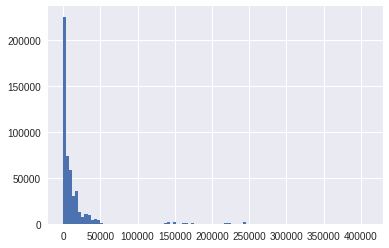

In [12]:
traffic_entry.AADT_entry.hist(bins=100)

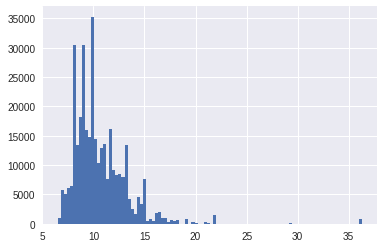

In [13]:
traffic_entry.K_FACTOR_entry.hist(bins=100)

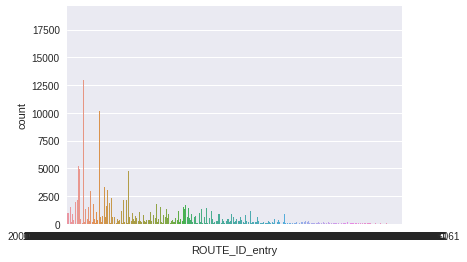

In [8]:
sns.countplot(x='ROUTE_ID_entry', data=traffic_entry)